In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips_robust, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def lin_func(x, a):
    return a * x

def xps_ws_fit_func(x, a, p):
    return a * x ** p

def xps_res_fit_func(x, a, b, c):
    return a * x ** 2 + b * x + c

In [6]:
# MacBook
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'therm_phase_si_crossing_test_cells'

no = 0
data_dir_gen = sorted(data_path.glob(f'reticle1/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    print(df.columns)
    ret = int(df['reticle'][no])
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]
    # currs = np.multiply(df['smu_current'][no], 1000)

# currs = [cr - currs[0] for cr in currs]  # for uncalibrated smu
elec_pwrs = np.multiply(volts, currs)
res = np.divide(volts[1:], np.divide(currs[1:], 1000))

print(currs)
print(volts)
print(len(volts))

Index(['Unnamed: 0', 'test_cell', 'device_no', 'device', 'position',
       'IK_min_width', 'PLN_offset', 'CA_offset_x', 'CA_offset_y', 'undercut',
       'index', 'reticle', 'wavelength', 'transmission_ch1',
       'transmission_ch2', 'laser_power_mw', 'smu_voltage', 'smu_current',
       'chuck_temperature', 'date'],
      dtype='object')
[-0.0058777130000000006, 0.5999875, 1.167803, 1.673159, 2.10759, 2.47309, 2.776123, 3.026013, 3.22956, 3.393887, 3.525418, 3.627187, 3.707834, 3.772091, 3.8259309999999997, 3.8736509999999997, 3.927067]
[0.0, 0.30000000000000004, 0.6000000000000001, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0, 3.3, 3.6, 3.9, 4.2, 4.5, 4.8]
17


(1305.0, 1312.0)

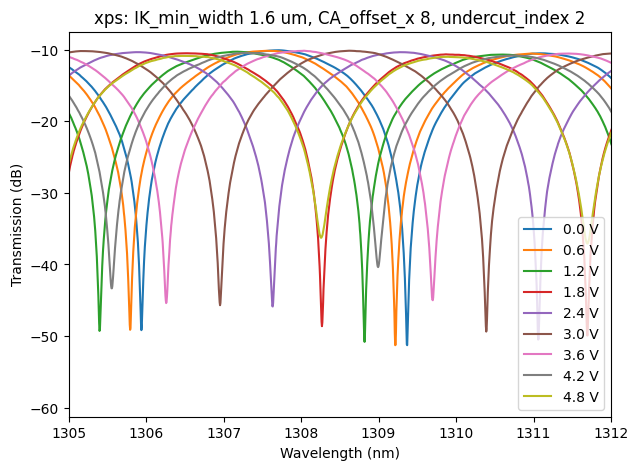

In [7]:
# plot tranmission spectra at different voltages
title = f"xps: IK_min_width {df['IK_min_width'][no]} um, CA_offset_x {df['CA_offset_x'][no]}, undercut_index {df['index'][no]}"
# title = f"thermphase_3splits: length {df['length'][no]} um, n_seg {df['n_seg'][no]}"
# title = df['device'][no]
wl_l, wl_u = 1305, 1312  # 1309, 1315

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in [0,2,4,6,8,10,12,14,16]:
    ax.plot(wavel, trans[i], label=f'{volts[i]:.2} V')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Transmission (dB)')
ax.set_title(title)
ax.legend()
ax.set_xlim([wl_l, wl_u])
# ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

[1305.942041710819, 1309.3691582934262]
3.427116582607141
[1304.2284834195154, 1311.0827165847297]
[4.60117864 0.940426  ]


Text(0.5, 0.98, 'Reticle 1')

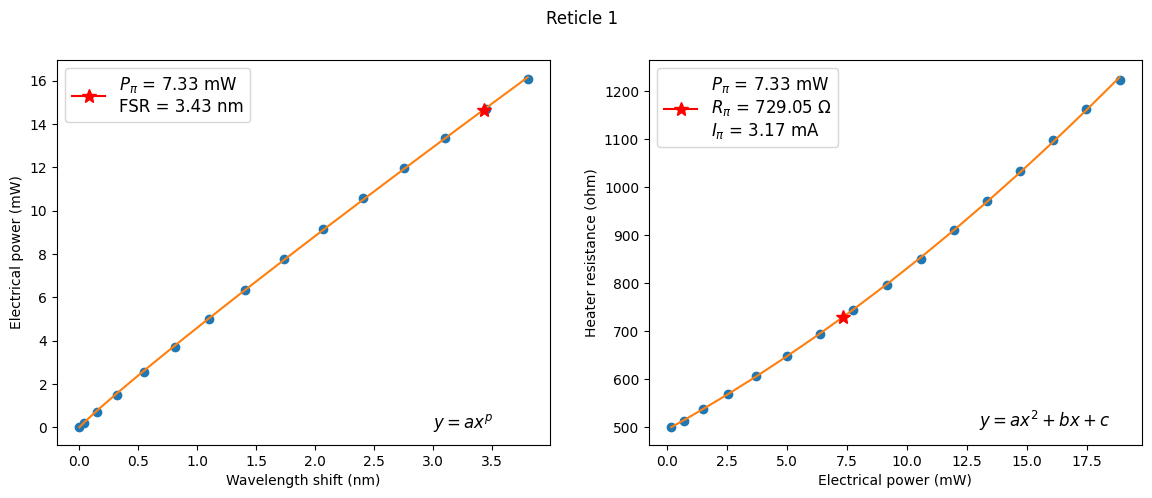

In [8]:
# Calculate FSR
wl_l, wl_u = 1305, 1312  # 1309, 1315
l_id, u_id = find_index(wl_l, wavel), find_index(wl_u, wavel)
v_u_id = 15
thres = -35

dips_0V = find_dips_robust(wavel[l_id:u_id], trans[0][l_id:u_id], thres)
FSR = abs(dips_0V[1] - dips_0V[0])
wavel_ref = dips_0V[0]
print(dips_0V)
print(FSR)

wl_range = [dips_0V[-1] - 1.5 * FSR, dips_0V[-1] + 0.5 * FSR]
l_id, u_id = find_index(wl_range[0], wavel), find_index(wl_range[1], wavel)
print(wl_range)

dips = []
for i in range(v_u_id):
    dips.append(find_dips_robust(wavel[l_id:u_id], trans[i][l_id:u_id], thres))

dip = []
for i in range(v_u_id):
    if i == 0:
        dip.append(dips[0][-1])
        continue

    dips[i].reverse()
    for d in dips[i]:  # the spectrum moves to the left side as voltages increases
        if d < dip[i-1]:
            dip.append(d)
            break

# for i in range(v_u_id):
#     if i == 0:
#         dip.append(dips[0][0])
#         continue
#     for d in dips[i]:
#         if d > dip[i-1]:
#             dip.append(d)
#             break

wavel_shift = np.array([abs(w - dip[0]) for w in dip])
p_opt, p_cov = curve_fit(xps_ws_fit_func, wavel_shift, elec_pwrs[:v_u_id])
P_pi = xps_ws_fit_func(FSR, *p_opt)/2
print(p_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(wavel_shift, elec_pwrs[:v_u_id], 'o')
ax.plot(wavel_shift, xps_ws_fit_func(wavel_shift, *p_opt))
ax.plot(FSR, 2*P_pi, marker='*', markersize=10, color='r', label='$P_{\pi}$' + f' = {P_pi:.2f} mW\n'+f'FSR = {FSR:.2f} nm')
ax.set_ylabel('Electrical power (mW)')
ax.set_xlabel('Wavelength shift (nm)')
# ax.set_title(title)
ax.legend(prop={'size':12})
ax.text(3, 0, '$y=ax^p$', fontsize=12)

ep_data, res_data = elec_pwrs[1:], res[:]
p_opt, p_cov = curve_fit(xps_res_fit_func, ep_data, res_data)
R_pi = xps_res_fit_func(P_pi, *p_opt)

ax = axes[1]
ax.plot(ep_data, res_data, 'o')
ax.plot(ep_data, xps_res_fit_func(ep_data, *p_opt))
ax.plot(P_pi, R_pi, marker='*', markersize=10, color='r', 
        label='$P_{\pi}$' + f' = {P_pi:.2f} mW\n' + '$R_{\pi}$' + f' = {R_pi:.2f} ' + '$\Omega$\n' + '$I_{\pi}$' + f' = {(1000*P_pi/R_pi)**0.5:.2f} mA')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Heater resistance (ohm)')
ax.legend(prop={'size':12})
ax.text(13, 500, '$y=ax^2+bx+c$', fontsize=12)

fig.suptitle('Reticle 1')